In [2]:
using DataFrames
using CSV

In [3]:
using Plots

In [4]:
FOLDER_WITH_DATA = "../../data"
SELF_ENERGY = "self_energy/jb_0.5"
CUTOFF=10
IB=0

0

# Test with BF

In [5]:
amplitude_values_BF_exact = DataFrame(
            CSV.File(
                "$(FOLDER_WITH_DATA)/$(SELF_ENERGY)/exact/BF/ampls_cutoff_$(CUTOFF)_ib_$(IB).0.csv",
            ),
        );
amplitude_values_BF_MC = DataFrame(
            CSV.File(
                "$(FOLDER_WITH_DATA)/$(SELF_ENERGY)/monte_carlo/Nmc_1000/BF/ampls_cutoff_$(CUTOFF)_ib_$(IB).0.csv",
            ),
        );

The due columns of the dataframe are amp and std

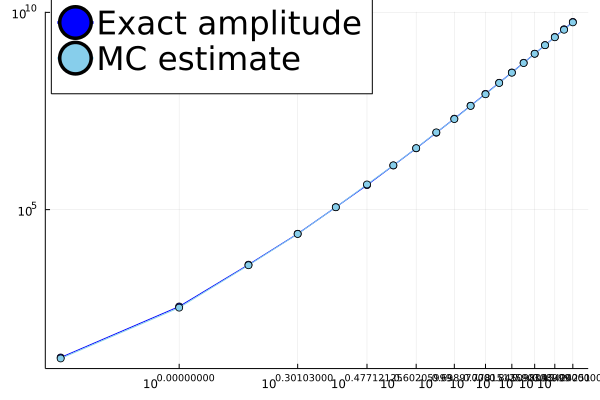

In [6]:
pl1 = plot(
        0.5:0.5:10,
        [amplitude_values_BF_exact.amp[2:end], amplitude_values_BF_MC.amp[2:end]],
        label = ["Exact amplitude" "MC estimate"],
        markershape = [:circle :circle :circle],
        shape = [:circle :circle :circle],
        xticks = 1:1:10,
        legend = (0.10, 0.97),
        yscale = :log10,
        xscale = :log10,
        palette = palette([:blue, :skyblue], 2),
        legendfontsize = 22,
    )

# Test with EPRL

In [7]:
Dl=10

10

In [8]:
amplitude_values_Dl_EPRL_MC = DataFrame(
            CSV.File(
                "$(FOLDER_WITH_DATA)/$(SELF_ENERGY)/monte_carlo/Nmc_1000/EPRL/immirzi_0.1/Dl_$(Dl)/flying_sampling_ampls_cutoff_$(CUTOFF)_ib_$(IB).0.csv",
            ),
        );
amplitude_values_Dlm1_EPRL_MC = DataFrame(
            CSV.File(
                "$(FOLDER_WITH_DATA)/$(SELF_ENERGY)/monte_carlo/Nmc_1000/EPRL/immirzi_0.1/Dl_$(Dl-1)/flying_sampling_ampls_cutoff_$(CUTOFF)_ib_$(IB).0.csv",
            ),
        );
amplitude_values_Dlm2_EPRL_MC = DataFrame(
            CSV.File(
                "$(FOLDER_WITH_DATA)/$(SELF_ENERGY)/monte_carlo/Nmc_1000/EPRL/immirzi_0.1/Dl_$(Dl-2)/flying_sampling_ampls_cutoff_$(CUTOFF)_ib_$(IB).0.csv",
            ),
        );
amplitude_values_Dl0m1m2_EPRL_MC=hcat(amplitude_values_Dl_EPRL_MC,amplitude_values_Dlm1_EPRL_MC,amplitude_values_Dlm2_EPRL_MC,makeunique=true)
rename!(amplitude_values_Dl0m1m2_EPRL_MC,["aDL","sDL","aDLm1","sDLm1","aDLm2","sDLm2"]);

Aitken extrapolation formula
$$A_{extrapolate} \approx \frac{A(\Delta l) A(\Delta l-2) - A(\Delta l-1)^2}{A(\Delta l) -2 A(\Delta l-1) + A(\Delta l-2)}$$

In [9]:
function extrapolate(A)
    num = A.aDL * A.aDLm2 - A.aDLm1^2 
    den = A.aDL  - 2* A.aDLm1 + A.aDLm2
    num/den
end

extrapolate (generic function with 1 method)

In [10]:
Amplitude_Extrapolated = Float64[]
for a in eachrow(amplitude_values_Dl0m1m2_EPRL_MC)
    push!(Amplitude_Extrapolated,extrapolate(a))
end

If all the error given by the extrapolation is 
$$\delta A_{extrapolate}^2 = \left(\frac{\partial A_{extrapolate}}{\partial A(\Delta l)}\right)^2 \delta A(\Delta l) ^2 + \left(\frac{\partial A_{extrapolate}}{\partial A(\Delta l-1)}\right)^2 \delta A(\Delta l-1) ^2+\left(\frac{\partial A_{extrapolate}}{\partial A(\Delta l-2)}\right)^2 \delta A(\Delta l-2) ^2 $$

In [11]:
function extrapolationerror(A)
    den = (A.aDL  - 2* A.aDLm1 + A.aDLm2)^2


    dDL   =   (A.aDLm1 - A.aDLm2)^2/den
    dDLm1 = 2*(A.aDL - A.aDLm1)*(A.aDLm1 - A.aDLm2)/den
    dDLm2 =   (A.aDL - A.aDLm1)^2/den

    Aerror = sqrt(dDL^2 * A.sDL^2 + dDLm1^2 * A.sDLm1^2 + dDLm2^2 * A.sDLm2^2)


    Aerror
end

extrapolationerror (generic function with 1 method)

In [12]:
Amplitude_Extrapolated_error = Float64[]
for a in eachrow(amplitude_values_Dl0m1m2_EPRL_MC)
    push!(Amplitude_Extrapolated_error,extrapolationerror(a))
end

In [13]:
Amplitude_Extrapolated,Amplitude_Extrapolated_error

([NaN, 1.0652069747272691e-6, 3.4371867517806614e-6, 6.514509746202029e-6, 9.882667631477026e-6, 1.3646263047270041e-5, 1.7258654943683773e-5, 2.1189422317058338e-5, 2.4868916734327586e-5, 2.8976247063523016e-5  …  3.713629247946211e-5, 4.069601624554956e-5, 4.493403847920096e-5, 4.8770869854305e-5, 5.273678226383058e-5, 5.683066221955328e-5, 6.128419234054833e-5, 6.51554046110688e-5, 6.973197385880894e-5, 7.382837069280548e-5], [NaN, 5.453794873183183e-7, 2.320457066169965e-6, 5.602267673271389e-6, 1.0474306926563524e-5, 1.7269578824774908e-5, 2.529576774188801e-5, 3.6894324932100035e-5, 5.045293337708056e-5, 6.783433703791732e-5  …  0.00011133057405304043, 0.00013338562695744304, 0.0001638251539943517, 0.00019616289364648095, 0.00023543798774592362, 0.0002774579612694205, 0.00033291541203464466, 0.000387491197163928, 0.00045171219088674695, 0.0005159145259090259])

In [15]:
DataFrame(Extrapolation = Amplitude_Extrapolated, MCError=Amplitude_Extrapolated_error)

,Extrapolation,MCError
,Float64,Float64
1,NaN,NaN
2,1.06521e-6,5.45379e-7
3,3.43719e-6,2.32046e-6
4,6.51451e-6,5.60227e-6
5,9.88267e-6,1.04743e-5
6,1.36463e-5,1.72696e-5
7,1.72587e-5,2.52958e-5
8,2.11894e-5,3.68943e-5
9,2.48689e-5,5.04529e-5


In [16]:
amplitude_values_Dl0m1m2_EPRL_MC

,aDL,sDL,aDLm1,sDLm1,aDLm2,sDLm2
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0
2,1.03819e-6,1.49e-8,1.03016e-6,1.48087e-8,1.01974e-6,1.469e-8
3,3.29718e-6,5.58913e-8,3.25856e-6,5.53202e-8,3.20928e-6,5.45911e-8
4,6.12714e-6,1.18033e-7,6.02835e-6,1.16301e-7,5.90435e-6,1.14124e-7
5,9.09917e-6,1.94409e-7,8.91354e-6,1.90709e-7,8.68393e-6,1.86128e-7
6,1.22672e-5,2.81891e-7,1.19638e-5,2.75308e-7,1.15936e-5,2.67264e-7
7,1.51465e-5,3.6669e-7,1.47123e-5,3.56677e-7,1.41889e-5,3.44583e-7
8,1.81176e-5,4.74681e-7,1.75278e-5,4.59536e-7,1.68247e-5,4.4148e-7
9,2.07448e-5,5.8352e-7,1.99994e-5,5.62628e-7,1.91193e-5,5.37972e-7
